In [3]:
import torch

In [4]:
dataset = "gas_649_max_sigma5_int"

In [5]:
checkpoint = torch.load(f"checkpoints/{dataset}/best_model.pt")

/tmp/ipykernel_2317798/4229518885.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"checkpoints/{dataset}/best_model.pt")


In [6]:
from experiments.downstream_model.model import GNN

model = GNN(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

GNN(
  (model): GAT(42, 785, num_layers=8)
  (ffn): Sequential(
    (0): Linear(in_features=785, out_features=785, bias=True)
    (1): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=785, out_features=785, bias=True)
    (4): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=785, out_features=900, bias=True)
  )
)

In [9]:
import os
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader

dataset_path = os.path.join("data/datasets", dataset)
graphs = torch.load(os.path.join(dataset_path, "graphs.pt"), weights_only=False)

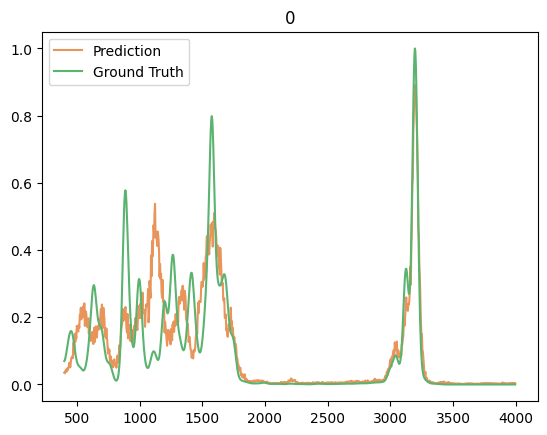

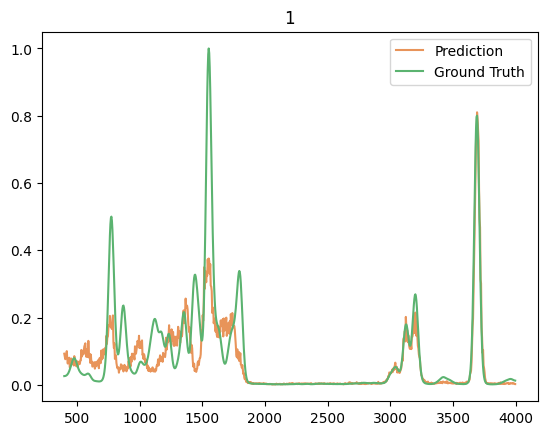

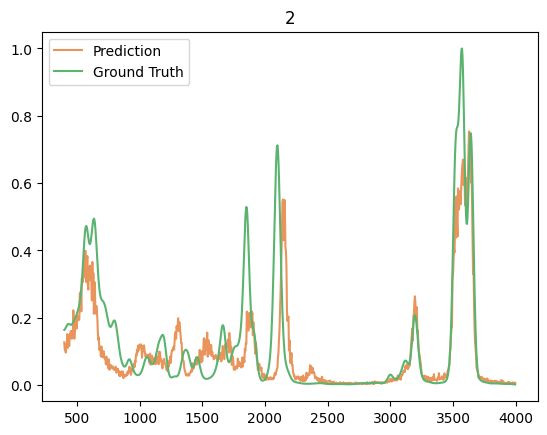

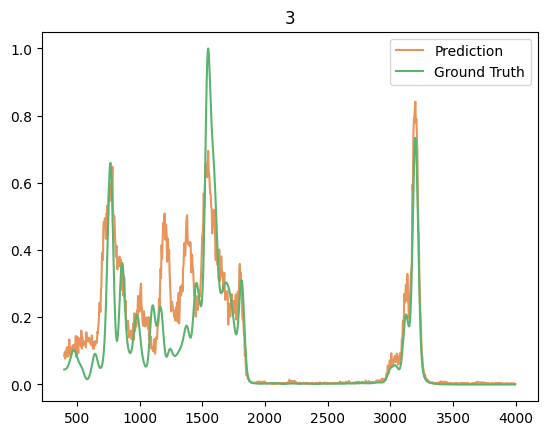

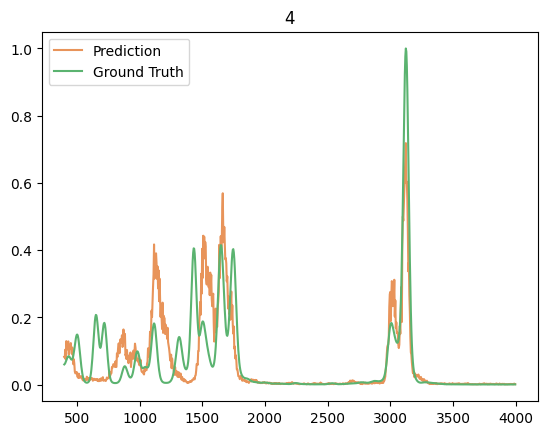

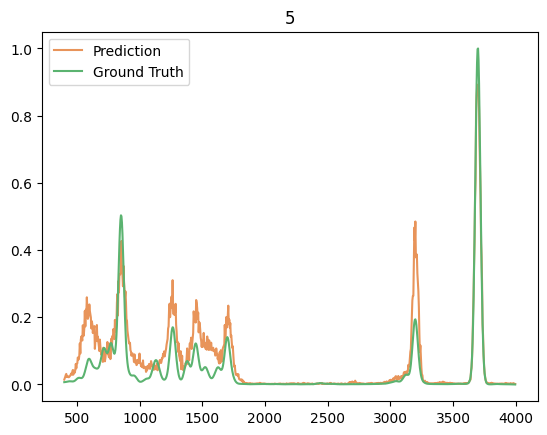

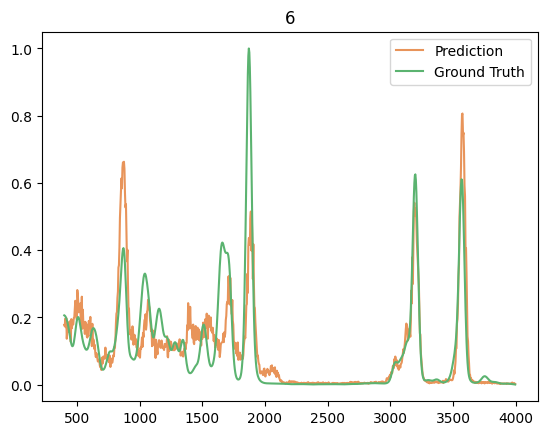

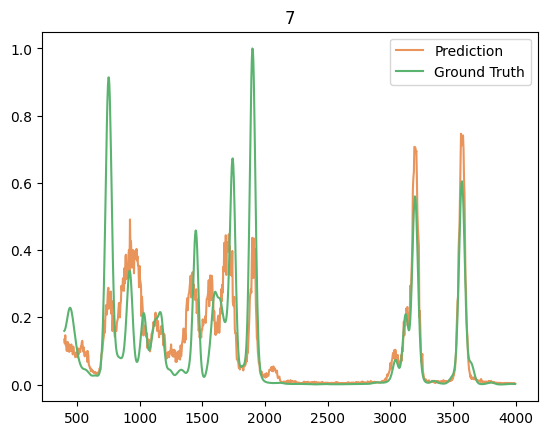

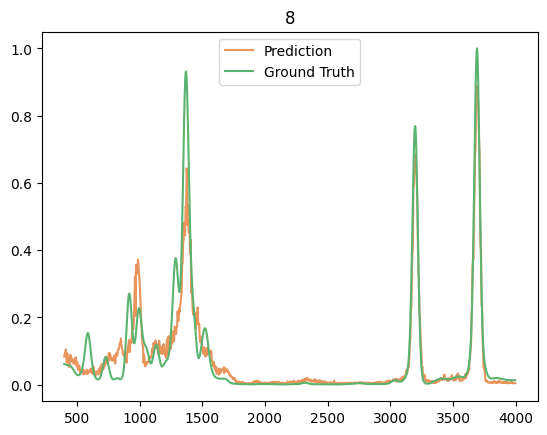

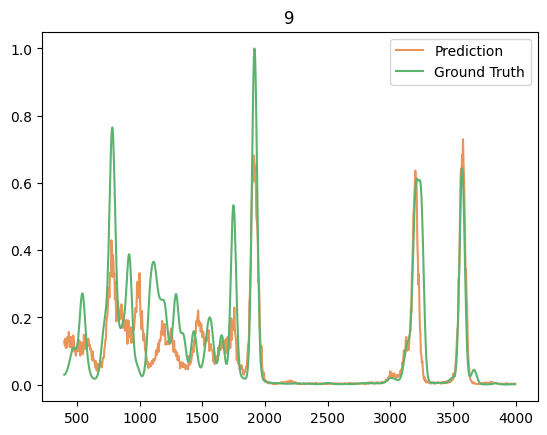

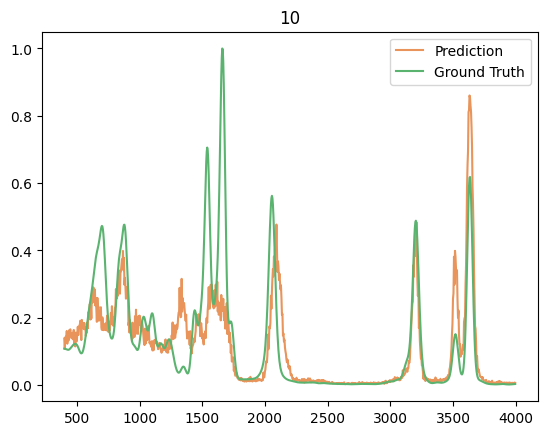

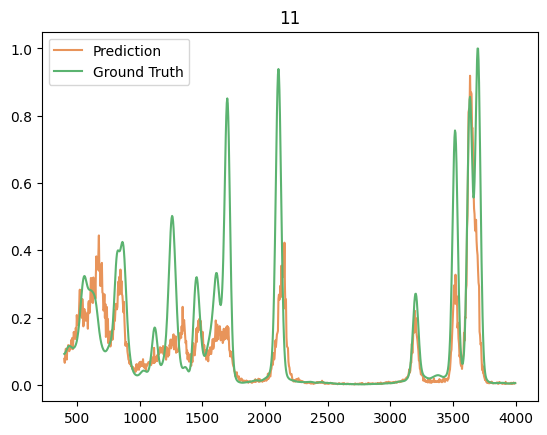

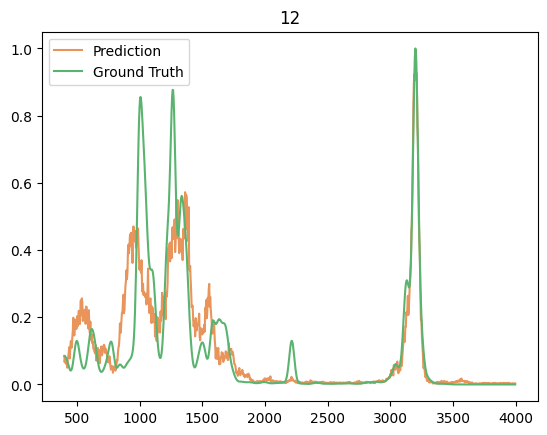

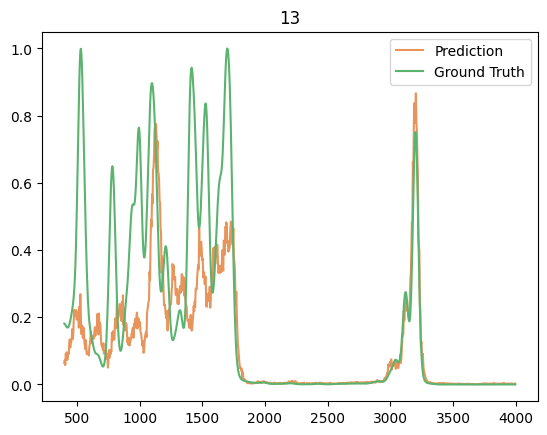

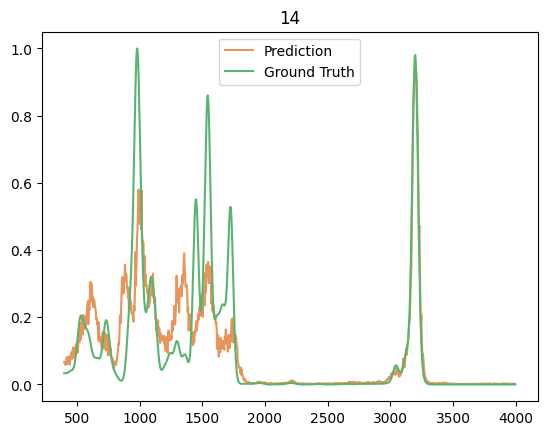

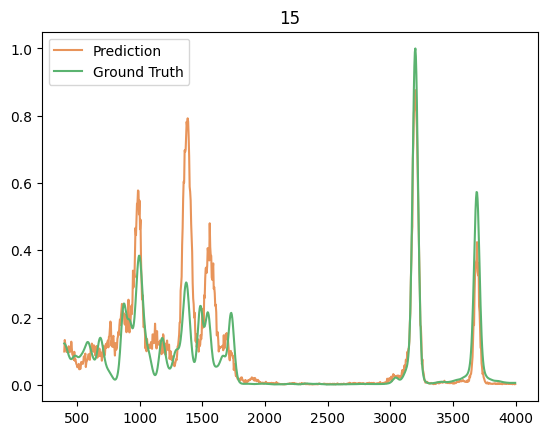

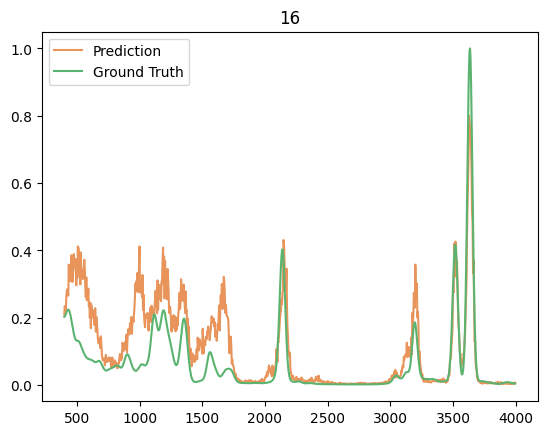

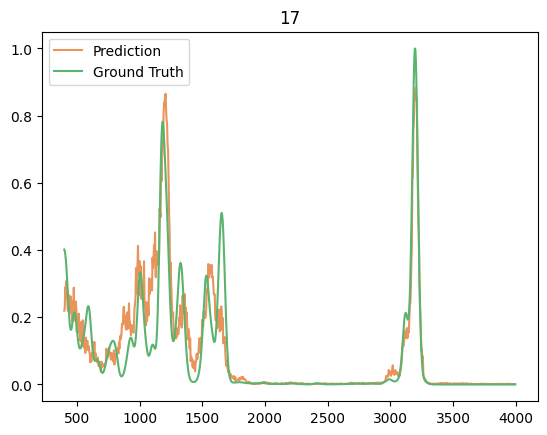

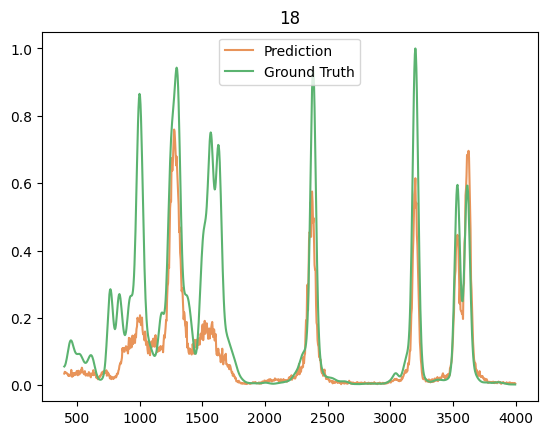

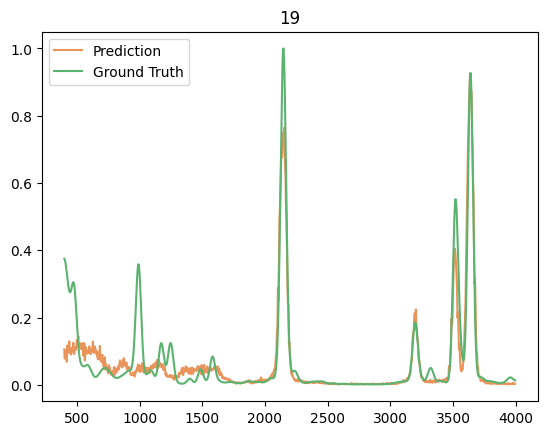

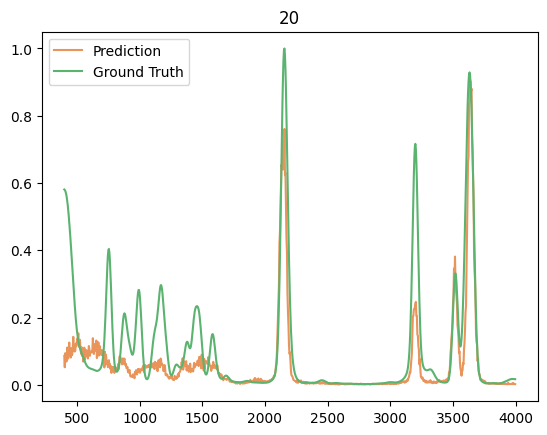

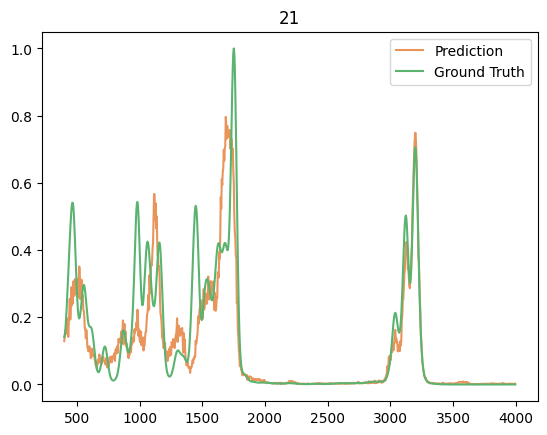

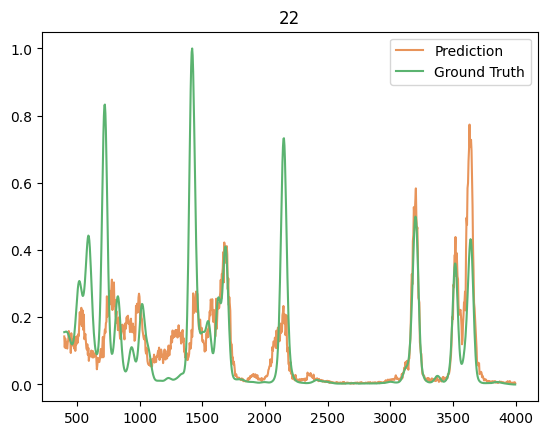

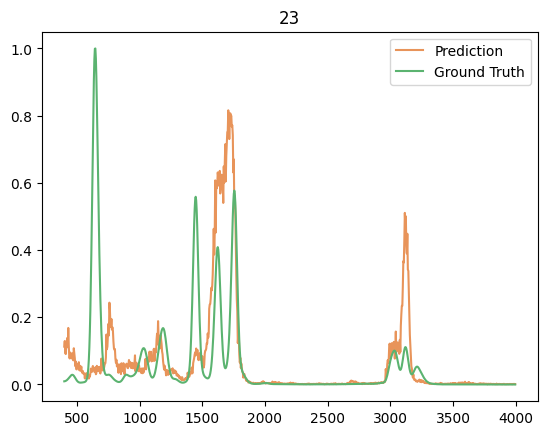

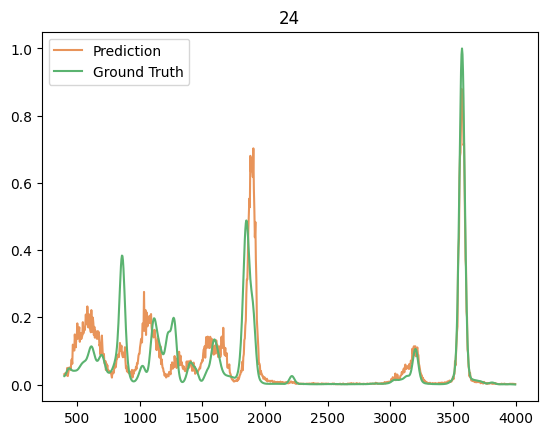

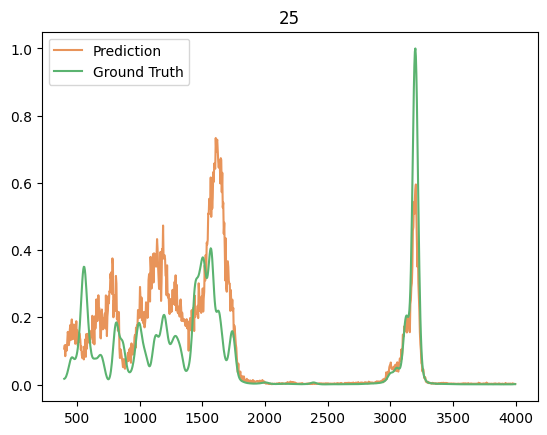

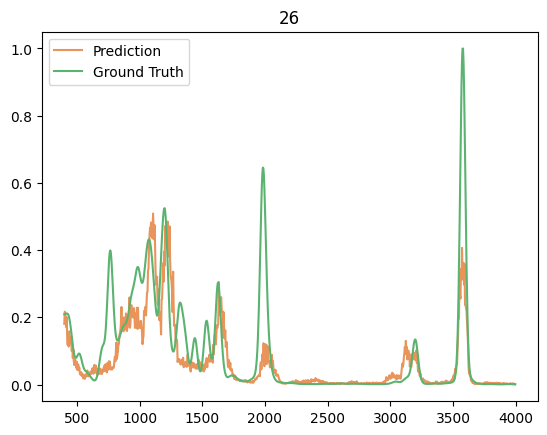

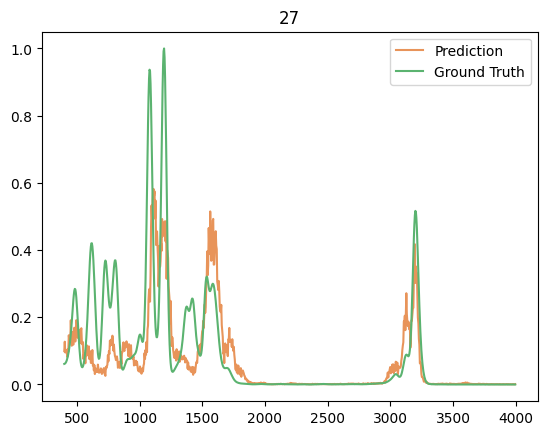

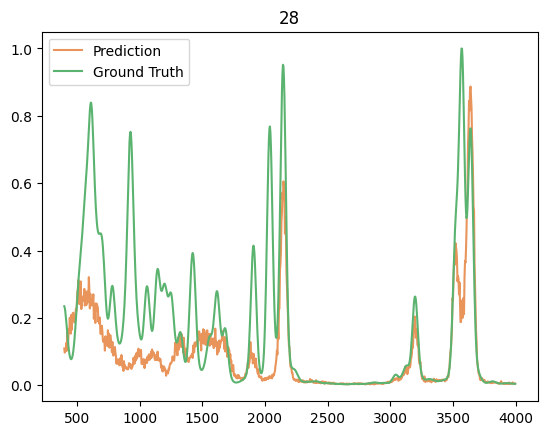

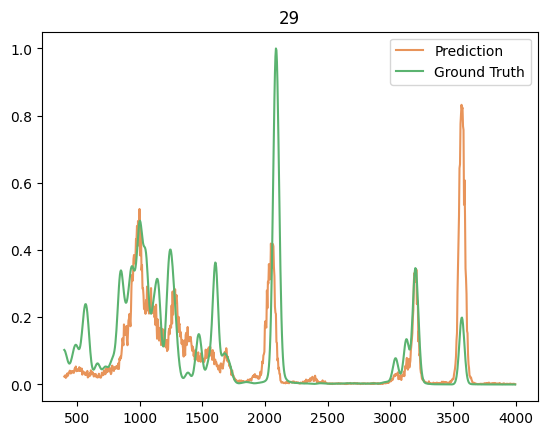

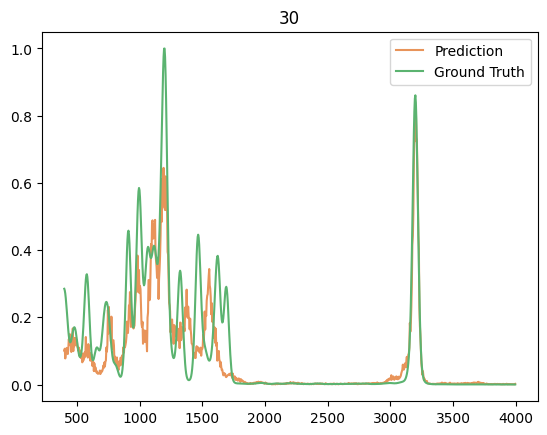

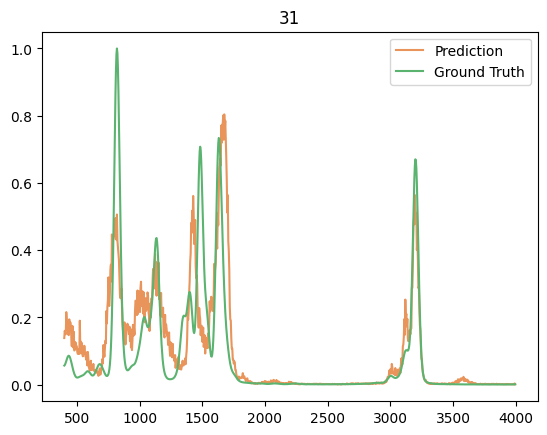

In [11]:
import matplotlib.pyplot as plt

test_indices = torch.load(os.path.join(dataset_path, "split", "test_indices.pt"), weights_only=False)
test_subset = Subset(graphs, test_indices)
test_loader = DataLoader(test_subset, batch_size=32, num_workers=0)

x_axis = torch.arange(400, 4000, step=4)
batch = next(iter(test_loader))

pred = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
batch_size = pred.shape[0]
dim = pred.shape[1]
target = batch.y.reshape(batch_size, dim)

for i in range(batch_size):
    plt.title(i)
    plt.plot(x_axis, pred[i].detach().cpu().numpy(), color="#E8945A", label="Prediction")
    plt.plot(x_axis, target[i].detach().cpu().numpy(), color="#5BB370", label="Ground Truth")
    plt.legend()
    plt.show()
    plt.close()

NameError: name 'x_values' is not defined

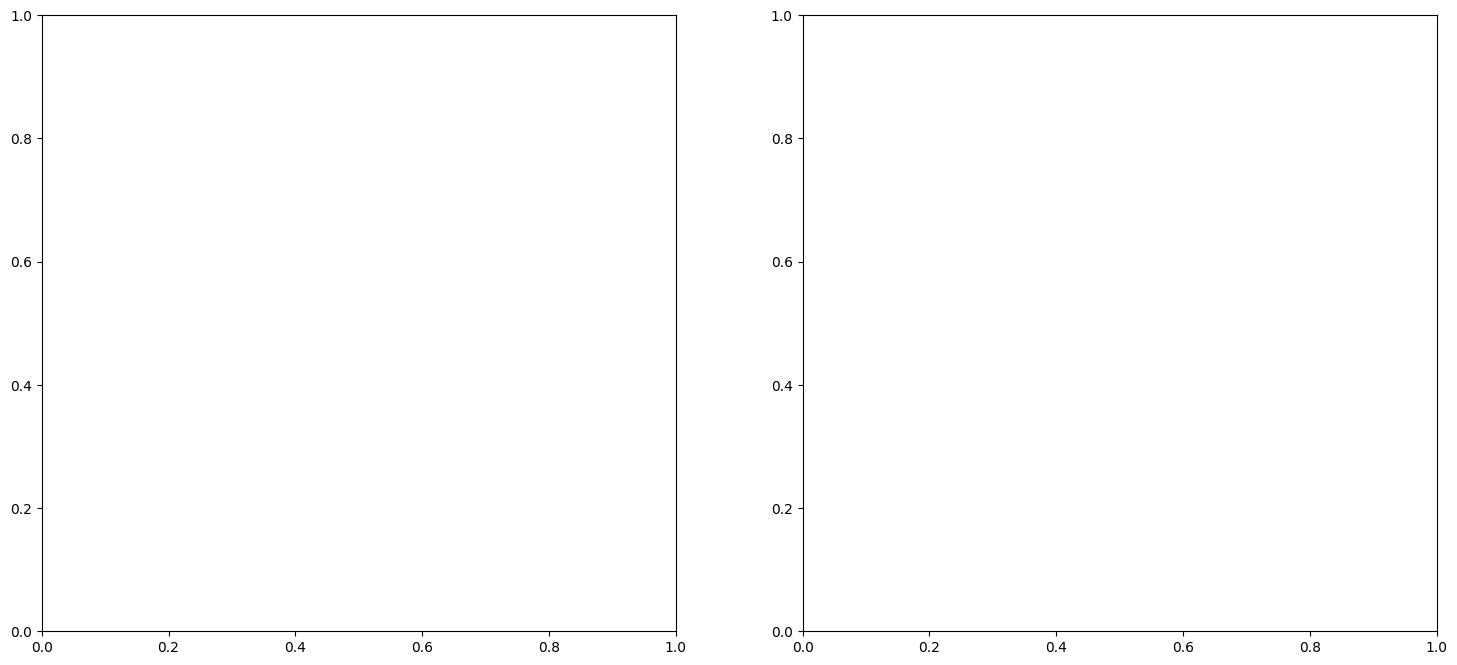

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.utils import to_networkx
from rdkit import Chem
from rdkit.Chem import AllChem

def visualize_molecular_graph_with_importance(data, importance_scores, top_n=5, ax=None):
    """
    Visualize a molecular graph with proper molecular layout and highlight important nodes.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # First create the NetworkX graph from PyG data
    G = to_networkx(data, to_undirected=True)
    
    # Fall back to spring layout by default
    pos = nx.spring_layout(G, seed=42)
    
    # Try to get positions from SMILES if available
    if hasattr(data, 'smiles'):
        try:
            mol = Chem.MolFromSmiles(data.smiles)
            if mol is not None:
                # Make sure molecule has the same number of atoms as our graph
                if mol.GetNumAtoms() == data.num_nodes:
                    # Generate 2D coordinates
                    AllChem.Compute2DCoords(mol)
                    
                    # Create positions dictionary from RDKit atom coordinates
                    rdkit_pos = {}
                    conf = mol.GetConformer()
                    for i in range(mol.GetNumAtoms()):
                        rdkit_pos[i] = [conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y]
                    
                    # Only use RDKit positions if we have positions for all nodes
                    if len(rdkit_pos) == len(G.nodes()):
                        pos = rdkit_pos
                        print("Using RDKit coordinates for molecular visualization")
                    else:
                        print(f"Node count mismatch: RDKit ({len(rdkit_pos)}) vs Graph ({len(G.nodes())})")
        except Exception as e:
            print(f"Error using RDKit for layout: {str(e)}")
            print("Falling back to spring layout")
    
    # Get indices of top important nodes
    top_indices = torch.argsort(importance_scores, descending=True)[:top_n].tolist()
    
    # Normalize importance scores for visualization
    norm_scores = importance_scores / importance_scores.max()
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.8, edge_color='darkgrey', ax=ax)
    
    # Set up node sizes and colors based on importance
    node_sizes = []
    node_colors = []
    cmap = plt.cm.YlOrRd
    
    for node in G.nodes():
        if node in top_indices:
            # Make important nodes larger and highlighted
            node_sizes.append(700 * float(norm_scores[node]))
            node_colors.append(cmap(float(norm_scores[node])))
        else:
            # Make other nodes smaller and grey
            node_sizes.append(300)
            node_colors.append('lightgrey')
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, ax=ax)
    nodes.set_edgecolor('black')
    nodes.set_linewidth(0.5)
    
    # Add node labels for important nodes only
    labels = {node: f"{node}" for node in top_indices}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_weight='bold', ax=ax)
    
    # Add a legend for top nodes
    for i, idx in enumerate(top_indices):
        score = importance_scores[idx].item()
        ax.text(0.05, 0.95 - i*0.05, f"Node {idx}: Score {score:.4f}", 
                transform=ax.transAxes, fontsize=10, 
                bbox=dict(facecolor=cmap(float(norm_scores[idx])), alpha=0.7, edgecolor='black'))
    
    ax.set_title(f'Molecular Graph with Top {top_n} Important Nodes Highlighted')
    ax.axis('off')
    
    return ax

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: The spectrum with the analyzed peak
with torch.no_grad():
    axes[0].plot(x_values, pred_reshaped.cpu(), label='Predicted')
    axes[0].plot(x_values, graph.y, label='Target')
    axes[0].axvline(x=x_values[wavenumber_index], color='r', linestyle='--')
axes[0].set_xlabel('Wavenumber (cm^-1)')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].set_title(f'Spectrum at {x_values[wavenumber_index].item()} cm^-1')

# Plot 2: The molecular graph with important nodes highlighted
visualize_molecular_graph_with_importance(graph, importance_scores, ax=axes[1])

plt.tight_layout()
plt.show()

# Print information about top nodes
print("\nTop 5 most important nodes:")
top_indices = torch.argsort(importance_scores, descending=True)[:5]
for i, idx in enumerate(top_indices):
    print(f"Node {idx.item()}: Importance score {importance_scores[idx].item():.6f}")

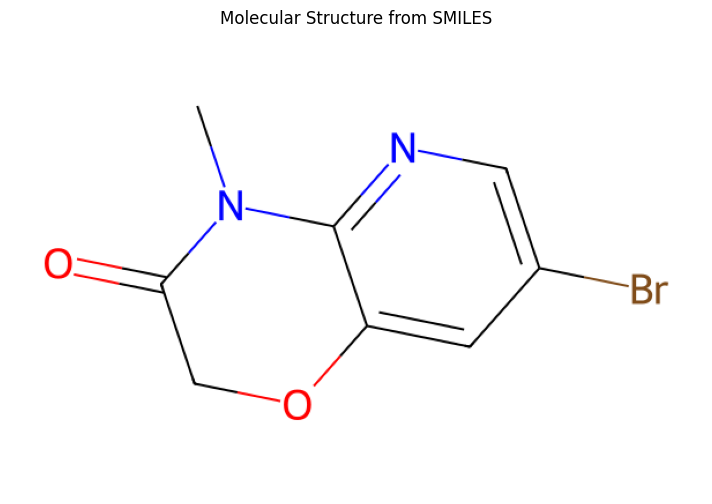

In [13]:
# Import necessary libraries for drawing molecular structures
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Check if the graph has a SMILES attribute
if hasattr(graph, 'smiles'):
    # Create RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(graph.smiles)
    
    # If molecule is valid, compute 2D coordinates and draw it
    if mol is not None:
        # Compute 2D coordinates
        AllChem.Compute2DCoords(mol)
        
        # Create a new figure for the molecule
        fig_mol = plt.figure(figsize=(10, 6))
        
        # Draw the molecule
        img = Draw.MolToImage(mol, size=(600, 400))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Molecular Structure from SMILES')
        plt.show()
    else:
        print("Could not create a valid molecule from the SMILES string.")
else:
    print("No SMILES attribute found in the graph object.")


Graph Connectivity Analysis:
- Is fully connected: False
- Number of connected components: 3307
- Component sizes: [88, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

/tmp/ipykernel_2007718/3575571220.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


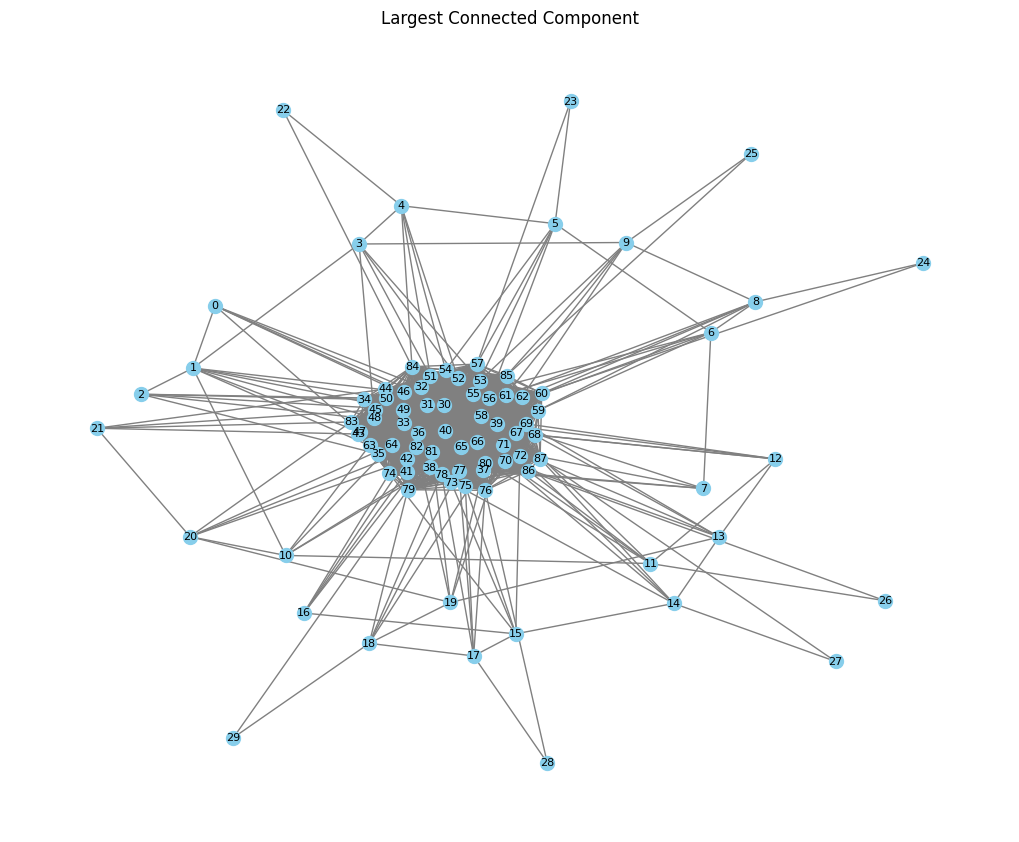

In [42]:
# Check if the graph is fully connected
import networkx as nx
import torch
from torch_geometric.utils import to_networkx

# Convert PyG graph to NetworkX for connectivity analysis
G = to_networkx(graph, to_undirected=True)

# Check if the graph is connected
is_connected = nx.is_connected(G)

# Get number of connected components
num_components = nx.number_connected_components(G)

# Print connectivity information
print(f"Graph Connectivity Analysis:")
print(f"- Is fully connected: {is_connected}")
print(f"- Number of connected components: {num_components}")

if not is_connected:
    # Get the sizes of all connected components
    component_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    print(f"- Component sizes: {component_sizes}")

# Create a figure to visualize connectivity information
plt.figure(figsize=(10, 8))

# Create a text box with connectivity information
connectivity_info = (
    f"Graph Connectivity Analysis:\n"
    f"- Is fully connected: {is_connected}\n"
    f"- Number of connected components: {num_components}"
)

if not is_connected:
    # Get the sizes of all connected components
    if not 'component_sizes' in locals():
        component_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    connectivity_info += f"\n- Component sizes: {component_sizes}"
    
    # Visualize the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    largest_cc_subgraph = G.subgraph(largest_cc)
    
    pos = nx.spring_layout(largest_cc_subgraph, seed=42)
    nx.draw(largest_cc_subgraph, pos, 
            node_color='skyblue', 
            node_size=100, 
            edge_color='gray',
            with_labels=True,
            font_size=8)
    plt.title("Largest Connected Component")
else:
    # If connected, just show the text information
    plt.text(0.5, 0.5, connectivity_info, 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=14,
             bbox=dict(facecolor='lightgreen', alpha=0.5))
    plt.axis('off')
    plt.title("Graph Connectivity Analysis")

plt.tight_layout()
plt.show()

